# Neural Steganography
### This is a project for the subject Information Security Management. This is a steganography algorithm trained by neural networks to encrypt text messages into images

## Importing the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

## Random Image Generator

In [2]:
def rand_img(size):
    return np.random.randint(0, 256, size) / 255.0

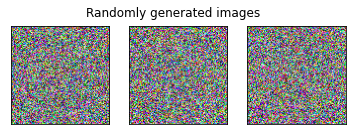

In [3]:
plt.figure(num=1, figsize=(6, 2))
for i in range(3):
    plt.subplot(1, 3, i+1), plt.imshow(rand_img((100, 100, 3)))
    plt.xticks([])
    plt.yticks([])
    plt.suptitle("Randomly generated images")

In [4]:
def rand_sentence(len, max):
    return np.random.randint(0, max, len)


def onehot(sentece, max):
    onehot = np.zeros((len(sentece), max))
    for i, v in enumerate(sentece):
        onehot[i, v] = 1
    return onehot

## Randomly generated sentences

In [5]:
str1=""
for i in range(5):
    result = str1.join(chr(int(j)) for j in rand_sentence(100, 256))
    print(result)

Æ6÷ÃcnËî 5OÊÙ«õÑÒ½f£üV¿±ºÐò]çùD
þ&ÿ/»c÷æ~ó»ðíCøÃhª­ðóHÌÝ©ÔØÈÛÂ\*m?LÏÕ7¤Ü¥R
eÍóC;þÑóËÂ¼wgÇe^Ìhy%e½ »Î1÷^
4aYxêª¯ÜR¸ål¶à^")¨:Ø)¥þ(Ò¬>¬¶°9\okíPçßð¶À;ú¯WÒG}®ÞC1q!¿Í}lkõx[×î¬ôÝÿØ
äÒÑ²VDqØ¦ªÖ¬dÃcR0_"ÇÃ£Ì6X¥¢È»øc2Èá[øH}|$Sâ£]_e¶c»}lÌy:Q`Ý½By¿[¤ã|
q~ nê[CÓ6=ØÎ)«,§§`Ê


## Data Generator function

In [6]:
def data_generator(image_size, sentence_len, sentence_max, batch_size=32):
    while True:
        x_img = np.zeros((batch_size, image_size[0], image_size[1], image_size[2]))
        x_sen = np.zeros((batch_size, sentence_len))
        y_img = np.zeros((batch_size, image_size[0], image_size[1], image_size[2]))
        y_sen = np.zeros((batch_size, sentence_len, sentence_max))
        for i in range(batch_size):
            img = rand_img(image_size)
            sentence = rand_sentence(sentence_len, sentence_max)
            sentence_onehot = onehot(sentence, sentence_max)
            x_img[i] = img
            x_sen[i] = sentence
            y_img[i] = img
            y_sen[i] = sentence_onehot
        yield [x_img, x_sen], [y_img, y_sen]

## Main Model

In [7]:
image_shape=(100, 100, 3)
sentence_len=100
max_word=256

input_img = Input(image_shape)
input_sen = Input((sentence_len,))
embed_sen = Embedding(max_word, 100)(input_sen)
flat_emb_sen = Flatten()(embed_sen)
flat_emb_sen = Reshape((image_shape[0], image_shape[1], 1))(flat_emb_sen)
trans_input_img = Conv2D(20, 1, activation="relu")(input_img)
enc_input = Concatenate(axis=-1)([flat_emb_sen, trans_input_img])
out_img = Conv2D(3, 1, activation='relu', name='image_reconstruction')(enc_input)

decoder_model = Sequential(name="sentence_reconstruction")
decoder_model.add(Conv2D(1, 1, input_shape=(100, 100, 3)))
decoder_model.add(Reshape((sentence_len, 100)))
decoder_model.add(TimeDistributed(Dense(max_word, activation="softmax")))
out_sen = decoder_model(out_img)

model = Model(inputs=[input_img, input_sen], outputs=[out_img, out_sen])
model.compile('adam', loss=['mae', 'categorical_crossentropy'], metrics={'sentence_reconstruction': 'categorical_accuracy'})
encoder_model = Model(inputs=[input_img, input_sen], outputs=[out_img])

In [9]:
image_shape = (100, 100, 3)
sentence_len = 100
max_word = 256

gen = data_generator(image_shape, sentence_len, max_word, 64)

model.fit(gen, epochs=128, steps_per_epoch=348, callbacks=[ModelCheckpoint("best_model.h5", monitor="loss", save_best_only=True),TensorBoard(log_dir='logs', histogram_freq=0, write_graph=True, write_images=False)])

Epoch 1/128
  1/348 [..............................] - ETA: 0s - loss: 5.9885 - image_reconstruction_loss: 0.4412 - sentence_reconstruction_loss: 5.5473 - sentence_reconstruction_categorical_accuracy: 0.0039WARNING:tensorflow:From /home/suyash/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
348/348 [==============================] - 25s 71ms/step - loss: 2.4768 - image_reconstruction_loss: 0.1793 - sentence_reconstruction_loss: 2.2976 - sentence_reconstruction_categorical_accuracy: 0.7787
Epoch 2/128
348/348 [==============================] - 22s 63ms/step - loss: 0.1457 - image_reconstruction_loss: 0.1337 - sentence_reconstruction_loss: 0.0120 - sentence_reconstruction_categorical_accuracy: 1.0000
Epoch 3/128
348/348 [==============================] - 22s 63ms/step - loss: 0.1328 - imag